# 구매이력 데이터 클러스터링

## 0. 데이터 로드

In [26]:
import numpy as np
import pandas as pd
import datetime as datetime
# import dataload
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [27]:
cd /

/


In [28]:
cd content/drive/MyDrive/2021/날씨 공모전/code

/content/drive/MyDrive/2021/날씨 공모전/code


In [29]:
buy_full = pd.read_csv('../data/data.csv', encoding='cp949')

## 1. 데이터 정제

In [30]:
buy_full['date'] = buy_full['date'].apply(lambda x : pd.to_datetime(str(x), format='%Y%m%d'))

In [31]:
buy_full['year'] = buy_full['date'].apply(lambda x : x.year)
buy_2018 = buy_full[buy_full.year==2018][['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']]
buy_2019 = buy_full[buy_full.year==2019][['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']]
buy_2018.shape, buy_2019.shape

((1005487, 6), (1051412, 6))

### 1-1. 2018, 2019 데이터를 요일에 맞추기

In [32]:
buy_2018["date"] = buy_2018["date"] + datetime.timedelta(days=-1)
buy_2018['date'] = buy_2018["date"].apply(lambda x : x.replace(year=2018, month=12, day=31) if x==datetime.date(2017, 12, 31) else x)

### 1-2. 데이터 재구조화

In [33]:
buy_2018_cat = buy_2018.groupby(['date', 'big_cat', 'sm_cat']).sum('qty').reset_index()[['date', 'big_cat', 'sm_cat', 'qty']]
buy_2019_cat = buy_2019.groupby(['date', 'big_cat', 'sm_cat']).sum('qty').reset_index()[['date', 'big_cat', 'sm_cat', 'qty']]
buy_2018_cat["date"] = buy_2018_cat["date"].apply(lambda x : str(x)[5:10])
buy_2019_cat["date"] = buy_2019_cat["date"].apply(lambda x : str(x)[5:10])
buy_2018_ts = pd.pivot_table(buy_2018_cat, index=['big_cat', 'sm_cat'], columns="date", values="qty")
buy_2019_ts = pd.pivot_table(buy_2019_cat, index=['big_cat', 'sm_cat'], columns="date", values="qty")
buy_2018_ts.shape, buy_2019_ts.shape

((383, 365), (383, 365))

In [34]:
buy_2018_ts.head()

date             01-01  01-02  01-03  01-04  ...  12-28  12-29  12-30  12-31
big_cat sm_cat                               ...                            
냉난방가전   가스온수기      NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN
        가열식 가습기   23.0   12.0   15.0   18.0  ...   15.0   23.0   16.0    7.0
        공기정화 용품  191.0  161.0  118.0  196.0  ...   61.0   80.0  150.0  120.0
        공기청정기    147.0  103.0   77.0  141.0  ...   84.0   88.0  289.0  106.0
        난방용 열풍기    NaN    NaN    1.0    1.0  ...    NaN    NaN    3.0    NaN

[5 rows x 365 columns]

In [35]:
buy_2019_ts.head()

date             01-01  01-02  01-03  01-04  ...  12-28  12-29  12-30  12-31
big_cat sm_cat                               ...                            
냉난방가전   가스온수기      NaN    1.0    NaN    NaN  ...    NaN    NaN    NaN    NaN
        가열식 가습기   26.0   27.0   27.0   20.0  ...   14.0    7.0   18.0   15.0
        공기정화 용품  116.0  160.0  144.0  142.0  ...  136.0  105.0  196.0  211.0
        공기청정기    138.0  159.0  113.0   93.0  ...   55.0   85.0  135.0   78.0
        난방용 열풍기    NaN    2.0    NaN    NaN  ...    NaN    NaN    1.0    1.0

[5 rows x 365 columns]

### 1-3. 결측치 처리

In [36]:
buy_2018_ts = buy_2018_ts.fillna(0)
buy_2019_ts = buy_2019_ts.fillna(0)

## 2. 시계열 클러스터링  
`식품` 대분류 데이터

In [37]:
buy_2018_food = buy_2018_ts.loc[('식품',)]
buy_2019_food = buy_2019_ts.loc[('식품',)]

### 2-1. 정규화

In [38]:
avg_lst = []; std_lst = []
for idx, row in tqdm(buy_2018_food.iterrows()):
    avg_lst.append(row.mean())
    std_lst.append(row.std())

In [39]:
buy_2018_food['avg'] = avg_lst
buy_2018_food['std'] = std_lst
buy_2018_food.head()

date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,avg,std
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,132.0,113.0,102.0,89.0,64.0,77.0,95.0,139.0,148.0,114.0,75.0,70.0,92.0,124.0,110.0,109.0,99.0,89.0,89.0,101.0,135.0,112.0,111.0,96.0,78.0,76.0,96.0,153.0,128.0,157.0,130.0,76.0,70.0,103.0,135.0,96.0,104.0,94.0,72.0,61.0,...,376.0,263.0,211.0,198.0,183.0,482.0,87.0,124.0,186.0,144.0,174.0,149.0,119.0,87.0,98.0,215.0,193.0,227.0,118.0,117.0,72.0,109.0,258.0,155.0,205.0,194.0,98.0,86.0,116.0,159.0,100.0,463.0,229.0,346.0,99.0,127.0,221.0,90.0,149.306849,70.207808
가자미,16.0,17.0,12.0,24.0,7.0,21.0,56.0,20.0,22.0,22.0,14.0,24.0,17.0,15.0,51.0,14.0,23.0,34.0,6.0,19.0,75.0,17.0,18.0,27.0,52.0,8.0,18.0,47.0,19.0,23.0,30.0,18.0,25.0,21.0,38.0,80.0,25.0,20.0,26.0,22.0,...,19.0,16.0,27.0,18.0,18.0,25.0,10.0,14.0,25.0,23.0,62.0,23.0,16.0,15.0,29.0,17.0,19.0,18.0,72.0,21.0,19.0,20.0,22.0,19.0,30.0,22.0,24.0,14.0,19.0,12.0,16.0,26.0,20.0,53.0,18.0,20.0,33.0,21.0,22.476712,15.612676
갈비/찜/바비큐용 돈육,7.0,5.0,13.0,9.0,12.0,6.0,9.0,20.0,15.0,13.0,13.0,17.0,18.0,19.0,16.0,12.0,10.0,10.0,12.0,12.0,7.0,12.0,14.0,22.0,16.0,4.0,17.0,13.0,5.0,18.0,5.0,7.0,9.0,13.0,11.0,18.0,18.0,18.0,21.0,14.0,...,16.0,19.0,11.0,17.0,21.0,18.0,15.0,13.0,11.0,28.0,16.0,13.0,16.0,18.0,13.0,12.0,15.0,22.0,16.0,21.0,19.0,25.0,46.0,27.0,21.0,21.0,9.0,12.0,17.0,20.0,21.0,24.0,12.0,12.0,22.0,20.0,17.0,22.0,14.671233,6.046193
갈비용 우육,2.0,2.0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,15.0,3.0,1.0,0.0,2.0,0.0,3.0,2.0,3.0,3.0,1.0,2.0,3.0,2.0,3.0,0.0,0.0,1.0,2.0,3.0,61.0,7.0,10.0,3.0,3.0,7.0,9.0,16.0,15.0,14.0,6.0,...,12.0,3.0,8.0,4.0,6.0,2.0,11.0,16.0,8.0,11.0,3.0,9.0,4.0,12.0,19.0,11.0,9.0,9.0,9.0,6.0,9.0,9.0,12.0,14.0,4.0,6.0,8.0,7.0,12.0,10.0,12.0,11.0,15.0,11.0,11.0,14.0,9.0,2.0,4.339726,4.981249
갈치,86.0,358.0,77.0,62.0,64.0,134.0,86.0,71.0,339.0,115.0,146.0,54.0,96.0,82.0,100.0,127.0,84.0,56.0,185.0,78.0,92.0,119.0,187.0,115.0,175.0,104.0,133.0,141.0,105.0,109.0,141.0,76.0,65.0,97.0,194.0,239.0,936.0,225.0,149.0,88.0,...,34.0,92.0,38.0,136.0,62.0,66.0,43.0,41.0,153.0,54.0,47.0,46.0,42.0,50.0,43.0,56.0,58.0,279.0,53.0,62.0,29.0,28.0,47.0,46.0,98.0,115.0,67.0,34.0,63.0,45.0,120.0,81.0,73.0,95.0,202.0,40.0,48.0,43.0,95.095890,89.018050


In [40]:
for i in tqdm(range(len(buy_2018_food))):
    for j in range(365):
        buy_2018_food.iloc[i,j] = (buy_2018_food.iloc[i,j] - buy_2018_food.iloc[i,365])/buy_2018_food.iloc[i,366]

In [41]:
buy_2018_food = buy_2018_food.drop(['avg','std'], axis=1)

In [42]:
avg_lst = []; std_lst = []
for idx, row in tqdm(buy_2019_food.iterrows()):
    avg_lst.append(row.mean())
    std_lst.append(row.std())

In [43]:
buy_2019_food['avg'] = avg_lst
buy_2019_food['std'] = std_lst
buy_2019_food.head()

date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,avg,std
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,262.0,288.0,215.0,167.0,231.0,251.0,330.0,329.0,352.0,257.0,243.0,146.0,276.0,322.0,270.0,241.0,721.0,214.0,119.0,191.0,251.0,248.0,220.0,166.0,298.0,124.0,143.0,245.0,162.0,550.0,95.0,73.0,65.0,45.0,123.0,52.0,107.0,225.0,207.0,202.0,...,172.0,270.0,231.0,217.0,171.0,200.0,138.0,166.0,417.0,248.0,225.0,195.0,126.0,92.0,145.0,176.0,288.0,192.0,151.0,154.0,85.0,127.0,232.0,196.0,181.0,183.0,150.0,74.0,123.0,205.0,182.0,170.0,281.0,178.0,129.0,149.0,186.0,212.0,217.934247,97.874000
가자미,22.0,35.0,28.0,42.0,24.0,26.0,30.0,36.0,53.0,63.0,25.0,35.0,35.0,45.0,69.0,23.0,24.0,22.0,10.0,74.0,21.0,69.0,74.0,21.0,46.0,23.0,23.0,69.0,26.0,21.0,10.0,11.0,9.0,4.0,12.0,2.0,9.0,37.0,21.0,15.0,...,15.0,37.0,25.0,28.0,29.0,32.0,20.0,30.0,80.0,47.0,22.0,29.0,27.0,19.0,20.0,26.0,24.0,37.0,29.0,26.0,22.0,26.0,35.0,33.0,31.0,36.0,36.0,26.0,29.0,28.0,15.0,34.0,24.0,39.0,49.0,27.0,29.0,57.0,30.589041,20.739512
갈비/찜/바비큐용 돈육,23.0,17.0,13.0,9.0,21.0,14.0,18.0,14.0,19.0,14.0,15.0,26.0,22.0,19.0,17.0,19.0,33.0,16.0,11.0,14.0,7.0,23.0,16.0,24.0,20.0,15.0,26.0,37.0,15.0,16.0,13.0,13.0,20.0,11.0,23.0,18.0,17.0,12.0,22.0,20.0,...,27.0,42.0,21.0,21.0,16.0,19.0,19.0,26.0,17.0,23.0,47.0,42.0,20.0,28.0,22.0,27.0,16.0,20.0,24.0,23.0,27.0,27.0,18.0,25.0,28.0,25.0,25.0,22.0,47.0,28.0,30.0,32.0,26.0,15.0,34.0,25.0,35.0,37.0,22.435616,11.044582
갈비용 우육,16.0,4.0,13.0,8.0,20.0,17.0,5.0,7.0,5.0,17.0,10.0,16.0,13.0,4.0,12.0,6.0,11.0,12.0,17.0,18.0,6.0,22.0,13.0,6.0,19.0,25.0,30.0,32.0,18.0,13.0,23.0,13.0,23.0,21.0,5.0,2.0,11.0,3.0,7.0,16.0,...,19.0,4.0,9.0,10.0,15.0,9.0,21.0,13.0,4.0,9.0,7.0,12.0,8.0,27.0,15.0,6.0,21.0,17.0,12.0,16.0,13.0,15.0,13.0,20.0,13.0,15.0,21.0,18.0,34.0,8.0,17.0,23.0,11.0,10.0,23.0,24.0,14.0,22.0,13.813699,6.569437
갈치,123.0,128.0,92.0,132.0,99.0,63.0,56.0,113.0,74.0,182.0,121.0,46.0,113.0,98.0,56.0,123.0,88.0,159.0,45.0,83.0,197.0,183.0,174.0,554.0,210.0,105.0,138.0,265.0,193.0,110.0,77.0,33.0,33.0,18.0,29.0,12.0,89.0,75.0,34.0,59.0,...,57.0,136.0,85.0,147.0,160.0,77.0,99.0,90.0,73.0,218.0,133.0,119.0,146.0,129.0,55.0,220.0,147.0,61.0,98.0,73.0,32.0,271.0,65.0,60.0,134.0,177.0,106.0,48.0,245.0,55.0,110.0,93.0,67.0,95.0,80.0,65.0,119.0,73.0,108.594521,136.483767


In [44]:
for i in tqdm(range(len(buy_2019_food))):
    for j in range(365):
        buy_2019_food.iloc[i,j] = (buy_2019_food.iloc[i,j] - buy_2019_food.iloc[i,365])/buy_2019_food.iloc[i,366]

In [45]:
buy_2019_food = buy_2019_food.drop(['avg','std'], axis=1)

In [46]:
buy_3 = (buy_2018_food + buy_2019_food) / 2
buy_3.head()

date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-22,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,0.101860,0.099372,-0.351896,-0.689691,-0.540783,-0.346029,0.185742,0.493989,0.675583,-0.051874,-0.401141,-0.932285,-0.111488,0.351403,-0.013949,-0.169220,2.211695,-0.449587,-0.934905,-0.481624,0.067031,-0.112095,-0.262257,-0.644948,-0.098802,-1.001944,-0.762446,0.164570,-0.437488,1.751183,-0.765521,-1.262483,-1.346082,-1.213238,-0.586871,-1.227329,-0.889382,-0.357783,-0.606416,-0.710298,...,-0.623107,-0.953629,1.379784,1.075674,0.506109,0.342006,0.000184,2.277727,-0.852084,-0.445540,1.278267,0.115800,0.211954,-0.119347,-0.685493,-1.087080,-0.737985,0.253622,0.669109,0.420821,-0.564899,-0.556695,-1.229666,-0.751601,0.845938,-0.071508,0.207948,0.139826,-0.712442,-1.186157,-0.722184,0.002956,-0.534723,1.989156,0.889730,1.196784,-0.812601,-0.511021,0.347439,-0.452682
가자미,-0.414488,-0.069051,-0.397938,0.323886,-0.654498,-0.157927,1.059391,0.051133,0.525029,0.766115,-0.406213,0.155126,-0.069051,0.107984,1.839499,-0.454430,-0.142094,0.161967,-1.024043,0.935234,1.450894,0.750640,0.903208,-0.086319,1.317027,-0.646581,-0.326329,1.711398,-0.221978,-0.214420,-0.255437,-0.615632,-0.439672,-0.688316,0.048982,1.152957,-0.439672,0.075242,-0.118344,-0.391096,...,-0.437879,-0.559139,-0.487172,-0.052859,0.010116,-0.205786,-0.181677,0.114825,-0.654857,-0.285670,1.272037,0.412403,1.058674,-0.021551,-0.293945,-0.518839,-0.046377,-0.286028,-0.270195,0.011191,1.547687,-0.157927,-0.318412,-0.189953,0.091075,-0.053218,0.250843,0.115184,0.179234,-0.382104,-0.149652,-0.397938,-0.583248,0.195068,-0.238170,1.180292,0.300494,-0.165844,0.298702,0.589438
갈비/찜/바비큐용 돈육,-0.608835,-1.045855,-0.565366,-1.077237,-0.285894,-1.098971,-0.669797,0.058782,-0.128346,-0.520095,-0.474824,0.353945,0.255557,0.202441,-0.136192,-0.376436,0.091966,-0.677643,-0.738605,-0.602791,-1.333172,-0.195352,-0.346856,0.676886,-0.000378,-1.219094,0.353945,0.521140,-1.136397,-0.016069,-1.226939,-1.061546,-0.579255,-0.655908,-0.278048,0.074473,0.029202,-0.197154,0.503647,-0.165772,...,-0.081273,0.149324,0.316519,1.243675,-0.368591,0.127589,0.232021,0.119744,-0.128346,0.023158,-0.549675,1.127795,1.221940,0.747495,-0.000378,0.527184,-0.157926,-0.014268,-0.264159,0.495802,0.180706,0.548918,0.564609,1.060789,2.389979,1.135640,0.775274,0.639460,-0.352900,-0.240623,1.304637,0.692577,0.865816,1.204448,-0.059539,-0.557520,1.129597,0.556764,0.761384,1.265410
갈비용 우육,-0.068454,-0.981774,-0.397160,-0.677334,0.035233,-0.092720,-1.006041,-0.753444,-1.006041,1.312550,-0.424738,-0.168830,-0.497537,-0.981774,-0.573647,-0.729178,-0.449004,-0.272518,0.108033,-0.016610,-0.829554,0.488583,-0.296784,-0.729178,-0.040877,0.415783,0.896710,1.149306,0.184143,5.625426,0.966198,0.506227,0.564693,0.412473,-0.403782,-0.431359,0.956266,0.247009,0.451073,0.333052,...,0.634181,0.561382,1.163640,-0.881398,0.001035,-0.324361,0.256942,-0.601224,1.215484,1.108486,-0.379516,0.302164,-0.653068,0.329741,-0.476581,1.772521,1.561835,0.073834,1.014731,0.710291,0.329741,0.333052,0.405851,0.558071,0.706980,1.440503,-0.096031,0.256942,0.914355,0.585648,2.305291,0.125677,1.011420,1.367704,0.855890,0.378274,1.367704,1.744943,0.481961,0.388206
갈치,0.001683,1.547781,-0.162435,-0.100150,-0.209810,0.051485,-0.243767,-0.119204,1.243235,0.380715,0.331367,-0.460140,0.021217,-0.112370,-0.165131,0.231974,-0.137771,-0.034938,0.272002,-0.189789,0.306479,0.406845,0.755820,1.743514,0.820301,0.036845,0.320626,0.830818,0.364844,0.083246,0.142091,-0.384194,-0.445980,-0.321192,0.263939,

## 3. Time-series Clustering

In [48]:
! pip install tslearn

     |████████████████████████████████| 798kB 4.3MB/s 


In [49]:
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


### DTW

#### 3-1. 최적 k

In [ ]:
'''
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in range(2, 7):
        ts_clustering = TimeSeriesKMeans(n_clusters=i, max_iter=param_max_iter, random_state=1234, metric = 'dtw')
        ts_clustering.fit(data)
        distortions.append(ts_clustering.inertia_)

    plt.plot(range(2, 7), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()
'''

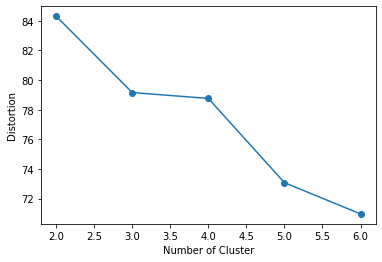

Wall time: 5min 1s


In [ ]:
'''
%%time
visualize_elbowmethod(buy_3)
'''

최적 K 개수 : *5* -> 이번엔 **3**으로 

#### 3-2. Clustering

In [50]:
%%time
model_dtw = TimeSeriesKMeans(n_clusters=3, init='random', n_init=10, max_iter=300, random_state=1234, metric = 'dtw').fit(buy_3)

CPU times: user 29min 40s, sys: 20min 2s, total: 49min 42s
Wall time: 27min 37s


In [51]:
result_dtw = model_dtw.predict(buy_3)
buy_3['cluster'] = result_dtw
buy_3.head()

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 212 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,cluster
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,0.101860,0.099372,-0.351896,-0.689691,-0.540783,-0.346029,0.185742,0.493989,0.675583,-0.051874,-0.401141,-0.932285,-0.111488,0.351403,-0.013949,-0.169220,2.211695,-0.449587,-0.934905,-0.481624,0.067031,-0.112095,-0.262257,-0.644948,-0.098802,-1.001944,-0.762446,0.164570,-0.437488,1.751183,-0.765521,-1.262483,-1.346082,-1.213238,-0.586871,-1.227329,-0.889382,-0.357783,-0.606416,-0.710298,...,-0.953629,1.379784,1.075674,0.506109,0.342006,0.000184,2.277727,-0.852084,-0.445540,1.278267,0.115800,0.211954,-0.119347,-0.685493,-1.087080,-0.737985,0.253622,0.669109,0.420821,-0.564899,-0.556695,-1.229666,-0.751601,0.845938,-0.071508,0.207948,0.139826,-0.712442,-1.186157,-0.722184,0.002956,-0.534723,1.989156,0.889730,1.196784,-0.812601,-0.511021,0.347439,-0.452682,2
가자미,-0.414488,-0.069051,-0.397938,0.323886,-0.654498,-0.157927,1.059391,0.051133,0.525029,0.766115,-0.406213,0.155126,-0.069051,0.107984,1.839499,-0.454430,-0.142094,0.161967,-1.024043,0.935234,1.450894,0.750640,0.903208,-0.086319,1.317027,-0.646581,-0.326329,1.711398,-0.221978,-0.214420,-0.255437,-0.615632,-0.439672,-0.688316,0.048982,1.152957,-0.439672,0.075242,-0.118344,-0.391096,...,-0.559139,-0.487172,-0.052859,0.010116,-0.205786,-0.181677,0.114825,-0.654857,-0.285670,1.272037,0.412403,1.058674,-0.021551,-0.293945,-0.518839,-0.046377,-0.286028,-0.270195,0.011191,1.547687,-0.157927,-0.318412,-0.189953,0.091075,-0.053218,0.250843,0.115184,0.179234,-0.382104,-0.149652,-0.397938,-0.583248,0.195068,-0.238170,1.180292,0.300494,-0.165844,0.298702,0.589438,1
갈비/찜/바비큐용 돈육,-0.608835,-1.045855,-0.565366,-1.077237,-0.285894,-1.098971,-0.669797,0.058782,-0.128346,-0.520095,-0.474824,0.353945,0.255557,0.202441,-0.136192,-0.376436,0.091966,-0.677643,-0.738605,-0.602791,-1.333172,-0.195352,-0.346856,0.676886,-0.000378,-1.219094,0.353945,0.521140,-1.136397,-0.016069,-1.226939,-1.061546,-0.579255,-0.655908,-0.278048,0.074473,0.029202,-0.197154,0.503647,-0.165772,...,0.149324,0.316519,1.243675,-0.368591,0.127589,0.232021,0.119744,-0.128346,0.023158,-0.549675,1.127795,1.221940,0.747495,-0.000378,0.527184,-0.157926,-0.014268,-0.264159,0.495802,0.180706,0.548918,0.564609,1.060789,2.389979,1.135640,0.775274,0.639460,-0.352900,-0.240623,1.304637,0.692577,0.865816,1.204448,-0.059539,-0.557520,1.129597,0.556764,0.761384,1.265410,1
갈비용 우육,-0.068454,-0.981774,-0.397160,-0.677334,0.035233,-0.092720,-1.006041,-0.753444,-1.006041,1.312550,-0.424738,-0.168830,-0.497537,-0.981774,-0.573647,-0.729178,-0.449004,-0.272518,0.108033,-0.016610,-0.829554,0.488583,-0.296784,-0.729178,-0.040877,0.415783,0.896710,1.149306,0.184143,5.625426,0.966198,0.506227,0.564693,0.412473,-0.403782,-0.431359,0.956266,0.247009,0.451073,0.333052,...,0.561382,1.163640,-0.881398,0.001035,-0.324361,0.256942,-0.601224,1.215484,1.108486,-0.379516,0.302164,-0.653068,0.329741,-0.476581,1.772521,1.561835,0.073834,1.014731,0.710291,0.329741,0.333052,0.405851,0.558071,0.706980,1.440503,-0.096031,0.256942,0.914355,0.585648,2.305291,0.125677,1.011420,1.367704,0.855890,0.378274,1.367704,1.744943,0.481961,0.388206,0
갈치,0.001683,1.547781,-0.162435,-0.100150,-0.209810,0.051485,-0.243767,-0.119204,1.243235,0.380715,0.331367,-0.460140,0.021217,-0.112370,-0.165131,0.231974,-0.137771,-0.034938,0.272002,-0.189789,0.306479,0.406845,0.755820,1.743514,0.820301,0.036845,0.320626,0.830818,0.364844,0.083246,0.142091,-0.384194,-0.445980,-0.321192,0.263939,0.454418,4.651439,0.606579,0.

In [52]:
buy_3_dtw = buy_3.reset_index()
buy_3_dtw.head()

date,sm_cat,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,...,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,cluster
0,가공란,0.101860,0.099372,-0.351896,-0.689691,-0.540783,-0.346029,0.185742,0.493989,0.675583,-0.051874,-0.401141,-0.932285,-0.111488,0.351403,-0.013949,-0.169220,2.211695,-0.449587,-0.934905,-0.481624,0.067031,-0.112095,-0.262257,-0.644948,-0.098802,-1.001944,-0.762446,0.164570,-0.437488,1.751183,-0.765521,-1.262483,-1.346082,-1.213238,-0.586871,-1.227329,-0.889382,-0.357783,-0.606416,...,-0.953629,1.379784,1.075674,0.506109,0.342006,0.000184,2.277727,-0.852084,-0.445540,1.278267,0.115800,0.211954,-0.119347,-0.685493,-1.087080,-0.737985,0.253622,0.669109,0.420821,-0.564899,-0.556695,-1.229666,-0.751601,0.845938,-0.071508,0.207948,0.139826,-0.712442,-1.186157,-0.722184,0.002956,-0.534723,1.989156,0.889730,1.196784,-0.812601,-0.511021,0.347439,-0.452682,2
1,가자미,-0.414488,-0.069051,-0.397938,0.323886,-0.654498,-0.157927,1.059391,0.051133,0.525029,0.766115,-0.406213,0.155126,-0.069051,0.107984,1.839499,-0.454430,-0.142094,0.161967,-1.024043,0.935234,1.450894,0.750640,0.903208,-0.086319,1.317027,-0.646581,-0.326329,1.711398,-0.221978,-0.214420,-0.255437,-0.615632,-0.439672,-0.688316,0.048982,1.152957,-0.439672,0.075242,-0.118344,...,-0.559139,-0.487172,-0.052859,0.010116,-0.205786,-0.181677,0.114825,-0.654857,-0.285670,1.272037,0.412403,1.058674,-0.021551,-0.293945,-0.518839,-0.046377,-0.286028,-0.270195,0.011191,1.547687,-0.157927,-0.318412,-0.189953,0.091075,-0.053218,0.250843,0.115184,0.179234,-0.382104,-0.149652,-0.397938,-0.583248,0.195068,-0.238170,1.180292,0.300494,-0.165844,0.298702,0.589438,1
2,갈비/찜/바비큐용 돈육,-0.608835,-1.045855,-0.565366,-1.077237,-0.285894,-1.098971,-0.669797,0.058782,-0.128346,-0.520095,-0.474824,0.353945,0.255557,0.202441,-0.136192,-0.376436,0.091966,-0.677643,-0.738605,-0.602791,-1.333172,-0.195352,-0.346856,0.676886,-0.000378,-1.219094,0.353945,0.521140,-1.136397,-0.016069,-1.226939,-1.061546,-0.579255,-0.655908,-0.278048,0.074473,0.029202,-0.197154,0.503647,...,0.149324,0.316519,1.243675,-0.368591,0.127589,0.232021,0.119744,-0.128346,0.023158,-0.549675,1.127795,1.221940,0.747495,-0.000378,0.527184,-0.157926,-0.014268,-0.264159,0.495802,0.180706,0.548918,0.564609,1.060789,2.389979,1.135640,0.775274,0.639460,-0.352900,-0.240623,1.304637,0.692577,0.865816,1.204448,-0.059539,-0.557520,1.129597,0.556764,0.761384,1.265410,1
3,갈비용 우육,-0.068454,-0.981774,-0.397160,-0.677334,0.035233,-0.092720,-1.006041,-0.753444,-1.006041,1.312550,-0.424738,-0.168830,-0.497537,-0.981774,-0.573647,-0.729178,-0.449004,-0.272518,0.108033,-0.016610,-0.829554,0.488583,-0.296784,-0.729178,-0.040877,0.415783,0.896710,1.149306,0.184143,5.625426,0.966198,0.506227,0.564693,0.412473,-0.403782,-0.431359,0.956266,0.247009,0.451073,...,0.561382,1.163640,-0.881398,0.001035,-0.324361,0.256942,-0.601224,1.215484,1.108486,-0.379516,0.302164,-0.653068,0.329741,-0.476581,1.772521,1.561835,0.073834,1.014731,0.710291,0.329741,0.333052,0.405851,0.558071,0.706980,1.440503,-0.096031,0.256942,0.914355,0.585648,2.305291,0.125677,1.011420,1.367704,0.855890,0.378274,1.367704,1.744943,0.481961,0.388206,0
4,갈치,0.001683,1.547781,-0.162435,-0.100150,-0.209810,0.051485,-0.243767,-0.119204,1.243235,0.380715,0.331367,-0.460140,0.021217,-0.112370,-0.165131,0.231974,-0.137771,-0.034938,0.272002,-0.189789,0.306479,0.406845,0.755820,1.743514,0.820301,0.036845,0.320626,0.830818,0.364844,0.083246,0.142091,-0.384194,-0.445980,-0.321192,0.263939,0.454418,4.651439,0.606579,0.029498,...,-0.427413,-0.532179,0.083009,-0.407135,0.370448,0.002427,-0.279172,-0.327763,-0.371968,0.194840,0.169971,

In [53]:
buy_3_dtw.to_csv('../data/food_tsclustering_norm_3.csv', encoding='CP949', index = False)
buy_3_dtw = pd.read_csv('../data/food_tsclustering_norm_3.csv', encoding='CP949')

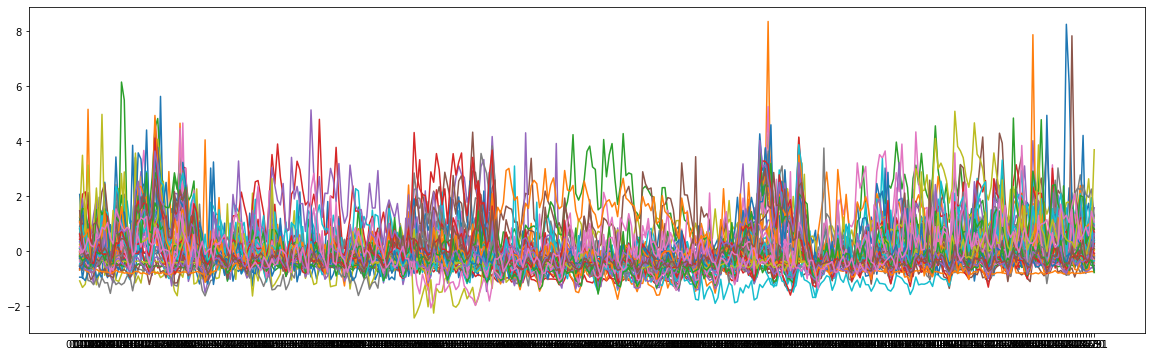

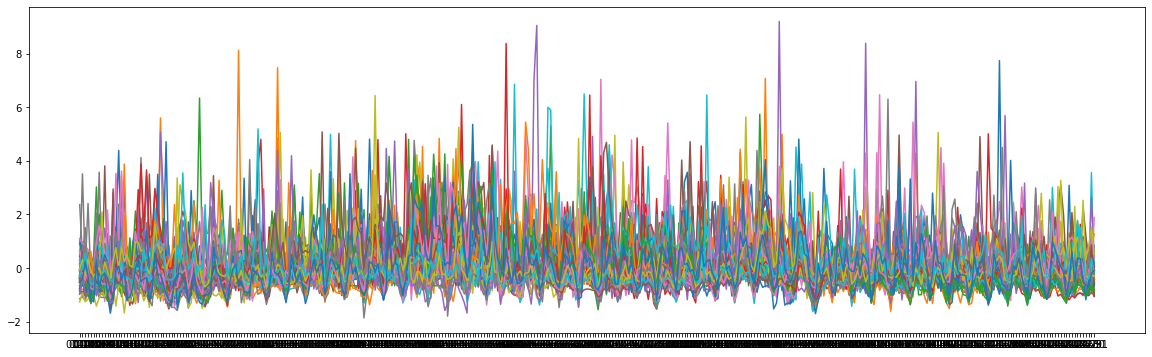

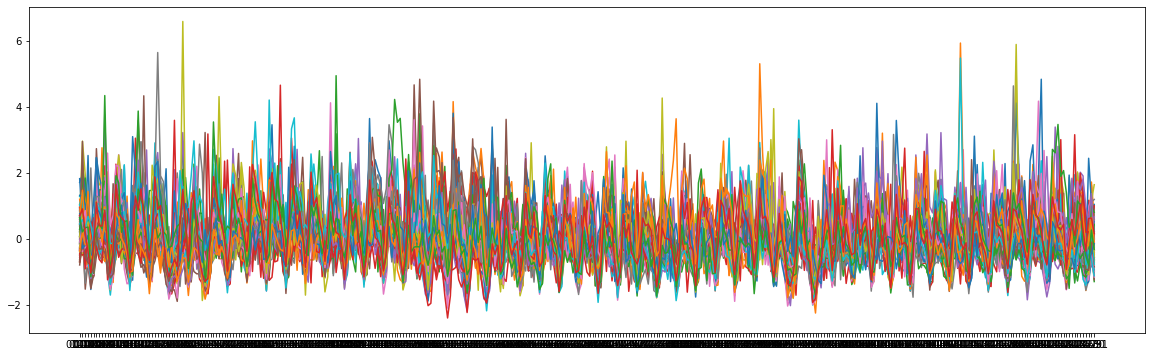

In [55]:
for i in range(3):
    clusters = buy_3_dtw.set_index('sm_cat')[buy_3_dtw.set_index('sm_cat')['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

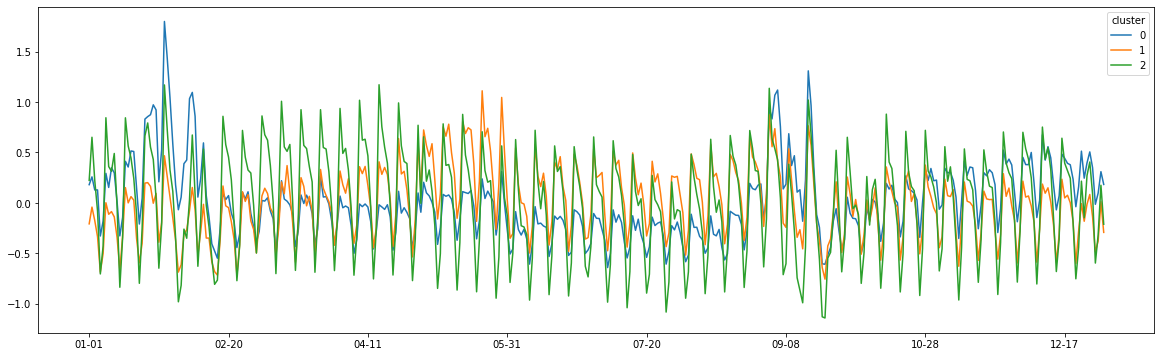

In [56]:
plt.rcParams["figure.figsize"]=(20,6)
buy_3_dtw.groupby(['cluster']).mean().T.plot()
plt.show()

In [57]:
pd.set_option('display.max_rows', 500)

* 명절

In [58]:
print(buy_3_dtw[buy_3_dtw["cluster"]==0]["sm_cat"].shape)
buy_3_dtw[buy_3_dtw["cluster"]==0]["sm_cat"]

(57,)


3           갈비용 우육
4               갈치
5             감/홍시
6       감귤/한라봉/오렌지
8             감말랭이
9               감자
13             건대추
19          건어물 멸치
22          건어물 황태
25             게장류
29           견과류 밤
38             곡물차
39          곶감/반건시
42            과일세트
46          국내산 돈육
47            굴 생물
48           굴비/조기
63          대게/킹크랩
66           돼지 곱창
69     딸기/복분자/블루베리
71             랍스타
77           명태/동태
78            무/배추
82             미나리
85         밀크티/티라떼
104            생선류
108      소고기 등심/안심
109         소고기 육회
110          수산 생물
114            시금치
122           양념우육
137             옥돔
138            옥수수
145            유자차
147            율무차
149           이온음료
157          전복 생물
158            전통주
160       절임배추/김치속
162             조개
164         차 선물세트
166       참외/메론/수박
175        코코아/핫초코
181           탄산음료
182            토마토
186           표고버섯
189     프로폴리스/로얄젤리
192            한우육
195           해초류 
199           혼합견과
200            혼합곡
202        홍삼 분말/환
203         

In [59]:
print(buy_3_dtw[buy_3_dtw["cluster"]==1]["sm_cat"].shape)
buy_3_dtw[buy_3_dtw["cluster"]==1]["sm_cat"]

(81,)


1               가자미
2      갈비/찜/바비큐용 돈육
10              갓김치
12           건강즙/녹용
14              건망고
15             건바나나
17          건어물 노가리
20           건어물 쥐포
21          건어물 진미채
23              건자두
24              건포도
26              견과류
28        견과류 마카다미아
30         견과류 잣/은행
31        견과류 카카오닙스
32          견과류 캐슈넛
33        견과류 피스타치오
35               계란
37       고추/피망/파프리카
40              과실차
41              과일류
45        구이/수육용 돈육
50           기타 농산물
51           기타 주스류
52        기타 한방/환제품
53              김치류
54               꽃게
56               낙지
61            닭 양념육
64             더치커피
65           도라지/더덕
72            레몬/자몽
74             마/야콘
79              무김치
80               문어
81              물김치
83        미숫가루/곡물가루
84            믹스 채소
86      바나나/파인애플/망고
87            바나나우유
89              반찬류
91             배추김치
94       복분자/석류/과실즙
99               삼치
100            상황버섯
102           새우/대하
103         생닭/닭부분육
105              생수
106        생식/선식 분말
111            수입우육


In [62]:
print(buy_3_dtw[buy_3_dtw["cluster"]==2]["sm_cat"].shape)
buy_3_dtw[buy_3_dtw["cluster"]==2]["sm_cat"]

(74,)


0                가공란
7         감마리놀렌산 영양제
11               건강즙
16           건어물 건새우
18         건어물 마른오징어
27            견과류 땅콩
34            견과류 호두
36               고등어
43        과일채소 분말/분태
44          과채 음료/주스
49     글루코사민/키토산 영양제
55                나물
57                녹차
58             느타리버섯
59           다이어트보조식
60      다이어트용 헬스보충식품
62              닭가슴살
67                두유
68              둥굴레차
70              딸기우유
73         루테인/눈 영양제
75             마늘/생강
76              메추리알
88            반건조고구마
90          배/포도/과일즙
92               백김치
93               보리차
95                부추
96          브로콜리/셀러리
97               비타민
98        비타민/화이바 음료
101            새송이버섯
107               선식
112     숙취/에너지/건강 음료
116                쌀
117              쌈채소
118       아몬드유/코코넛밀크
120           야채/호박즙
123          양배추/양상추
124           양파/마늘즙
127           어린이영양제
128            어린이홍삼
132             영지버섯
134    오메가3/스쿠알렌 영양제
136              오징어
139             옥수수차
141          요거트/발효유
142          